In [2]:
import tqdm
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [ ]:
first = time.clock()

In [ ]:
# 手动添加特征，训练集42，测试集41
# 有l
feather = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
           'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 
           'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

In [3]:
# 手动添加特征，训练集42，测试集41
# 没有l
feather = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
           'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

In [4]:
# TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\UNSW-NB 15\\UNSW_NB15_training-set.csv'
TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\train_10_percent_kddcup.csv'
TEST_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\test_10_percent_kddcup.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATA_PATH, header = None, names = feather)
test_df = pd.read_csv(TEST_DATA_PATH, header = None, names = feather)

C:\Users\Qin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


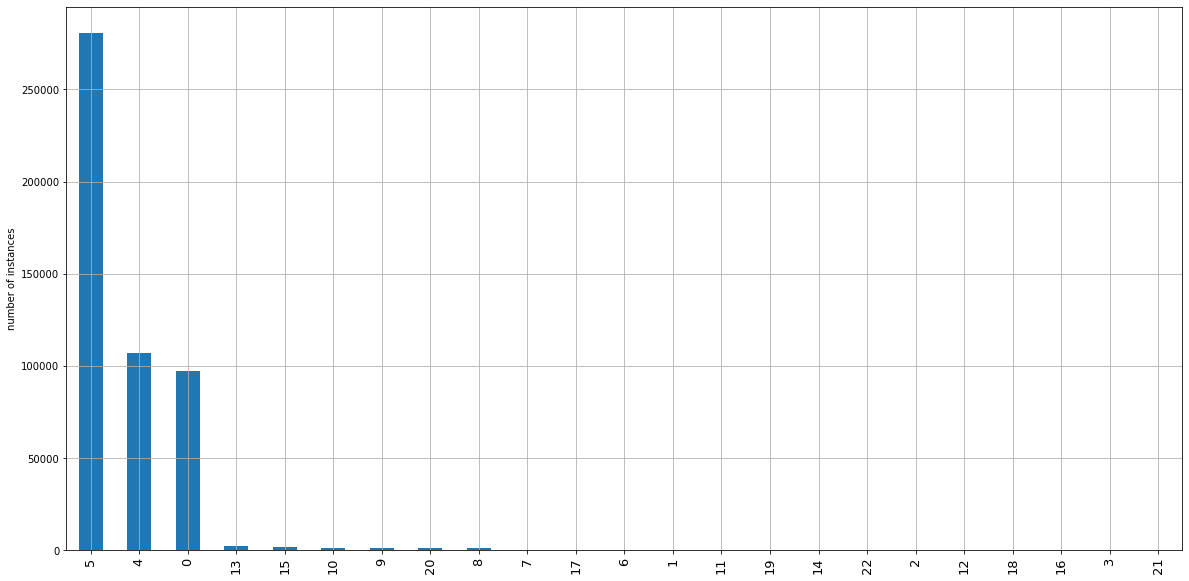

In [6]:
# train
pd.value_counts(train_df['label']).plot(kind = 'bar', figsize = (20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize = 13)
plt.grid()
plt.show()

In [7]:
# train_df_http = train_df[train_df['service'] == 21]

In [17]:
train_df_http = train_df

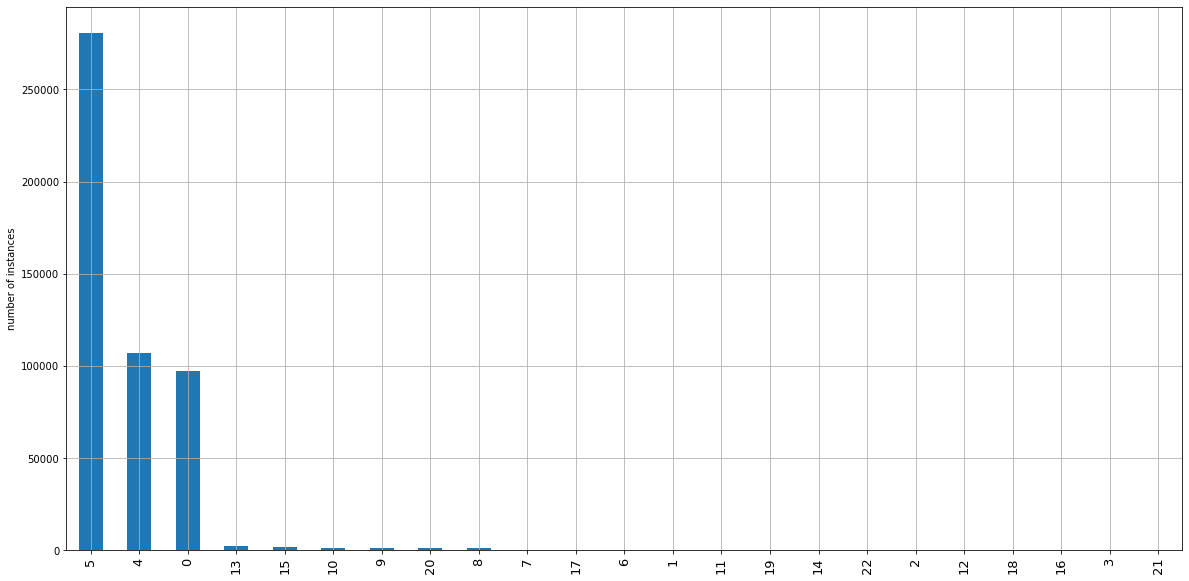

In [18]:
pd.value_counts(train_df_http['label']).plot(kind = 'bar', figsize = (20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize = 13)
plt.grid()
plt.show()

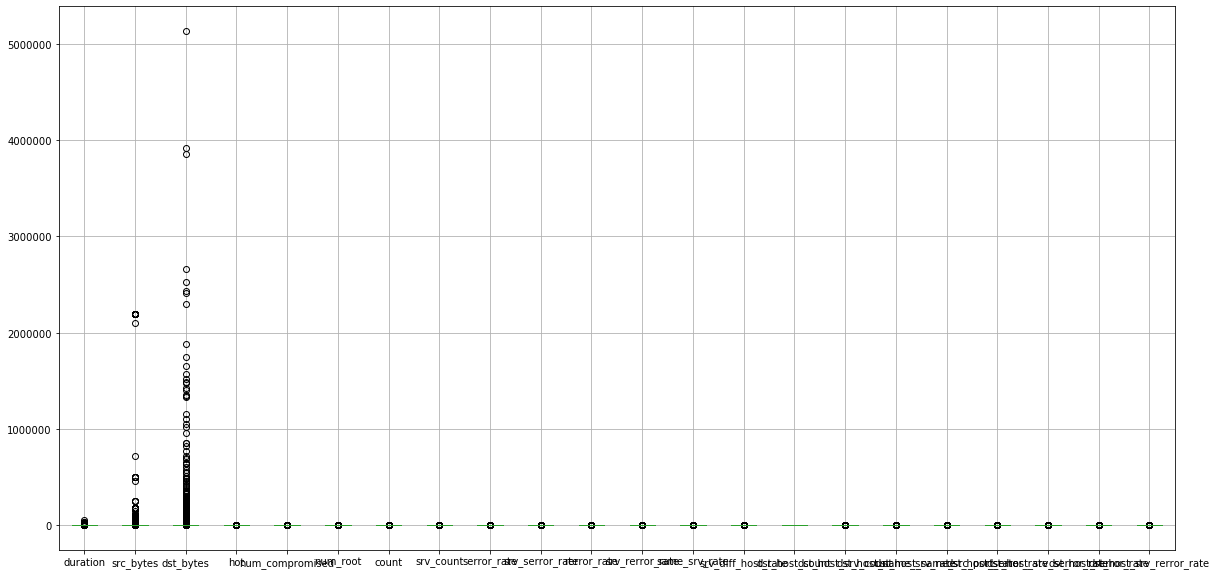

In [19]:
train_normal_instances = train_df_http[train_df_http['label'] == 0].shape[0]
train_anomalous_instances = train_df_http[train_df_http['label'] != 0].shape[0]

# 只提取属于"normal"的实例
train_df_http_normal = train_df_http[train_df_http['label'] == 0]

# 删除所有分类列
# train_df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
# train_df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

train_df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
train_df_http_normal.drop(['num_outbound_cmds', 'urgent', 'num_shells', 'num_failed_logins', 'num_access_files', 'dst_host_srv_diff_host_rate', 'diff_srv_rate', 'num_file_creations', 'dst_host_diff_srv_rate', 'wrong_fragment'], axis = 1, inplace = True)

train_df_http_normal.boxplot(figsize = (20, 10))
plt.show()

No handles with labels found to put in legend.


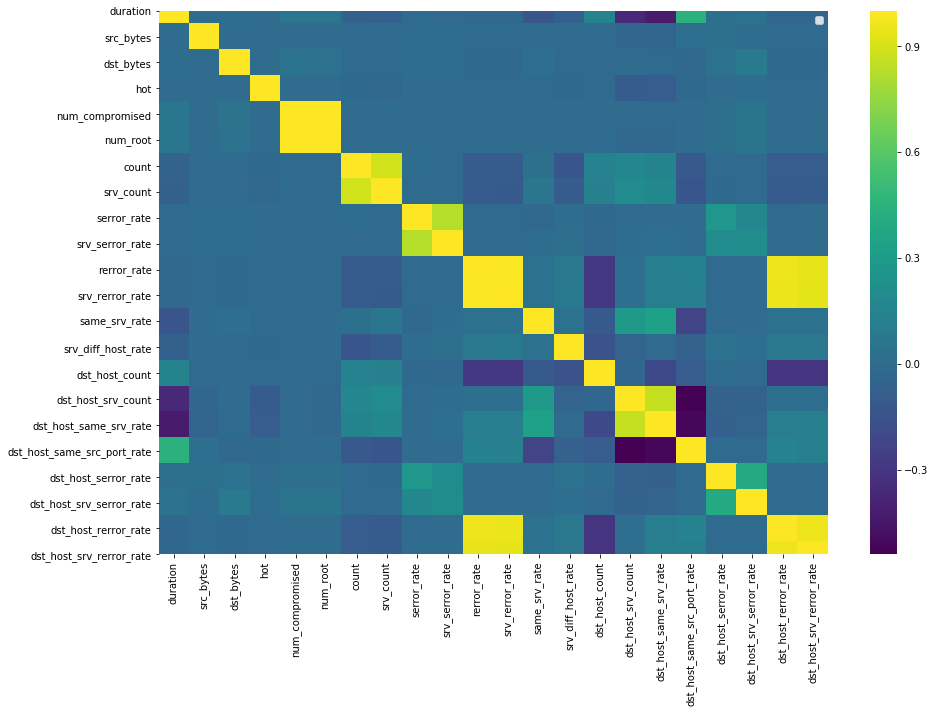

In [21]:
# train
# 热图，描述各个特征之间存在的相关性
scaler = StandardScaler()
train_df_http_normal = pd.DataFrame(scaler.fit_transform(train_df_http_normal), columns = train_df_http_normal.columns)

plt.figure(figsize = (15, 10))
sns.heatmap(train_df_http_normal.corr(), cmap = 'viridis')
plt.legend()
plt.savefig('./correlations.jpg')
plt.show()

In [ ]:
# train
# 采用主成分分析法对数据进行降维，覆盖原始数据80%的方差
# ｎ＿components：指定希望PCA降维后的特征维度数目
# 最常用的做法是直接指定降维到的维度数目，此时n_components是一个大于等于1的整数。
# 当然，我们也可以指定主成分的方差和所占的最小比例阈值，让PCA类自己去根据样本特征方差来决定降维到的维度数，
# 此时n_components是一个（0，1]之间的数。
pca = PCA(n_components = 0.8)
pca.fit(train_df_http_normal)

pca_cols = ['PCA_' + str(i) for i in range(pca.n_components_)]
train_df_pca = pd.DataFrame(pca.transform(train_df_http_normal), columns = pca_cols)

In [ ]:
train_df_http_normal.shape

In [ ]:
train_df_pca.shape

In [ ]:
# 采用特定的窗口长度和步长从数据中提取窗口
def get_windows(df, window_size = 10, stride = 5) :
    windows_arr = []
    for i in tqdm.tqdm(range(0, len(df) - window_size + 1, stride)) :
        windows_arr.append(df.iloc[i : i + window_size, : ].to_numpy())
        
    return np.array(windows_arr)

In [ ]:
K.clear_session()

# 带堆叠LSTM的编码器模型
window_size = 10
encoder = Sequential([LSTM(80, return_sequences = True, activation = 'selu', input_shape = (window_size, 13), dropout = 0.2), 
                      LSTM(50, activation = 'selu', return_sequences = True), 
                      LSTM(20, activation = 'selu')], name = 'encoder')


# 输出维与输入维相同的解码器模型
decoder = Sequential([RepeatVector(window_size), 
                      LSTM(50, activation = 'selu', return_sequences = True), 
                      LSTM(80, activation = 'selu', return_sequences = True), 
                      TimeDistributed(Dense(13, activation = 'linear'))], name = 'decoder')

# 使用编码器、解码器作为层创建顺序自动编码器
autoencoder = Sequential([encoder, decoder], name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

encoder.summary()
decoder.summary()

In [ ]:
# 训练自编码器
# 训练时使用模型checkpoint回调，以保证在验证集上具有最佳性能的模型和权重
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)
windows_shuffled = get_windows(train_df_pca)

# 记录训练时间
start_time=time.clock()
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size = 64, validation_split = 0.15, epochs = 50, callbacks = [check_point])
end_time=time.clock()

print("train time : ", (end_time - start_time))

# 用最佳权重集加载自动编码器
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

In [ ]:
test_df_http = test_df

In [ ]:
# 代表异常的二进制指示符
status = pd.Series([0 if i == 0 else 1 for i in test_df_http['label']])
window_size = 10
test_labels = [1 if np.sum(status[i : i + window_size]) > 0 else 0 for i in range(0, len(status)-window_size + 1, 5)]

# 删除所有分类列
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
# test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

test_df_http = pd.DataFrame(scaler.transform(test_df_http), columns = test_df_http.columns)
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns = pca_cols)

In [ ]:
# 从测试数据中提取窗口
test_windows = get_windows(test_df_http_pca, window_size = 10, stride = 5)

In [ ]:
# 使用已训练过的自编码器对测试窗口进行重构
# 测试用时
start_time=time.clock()
test_windows_pred = autoencoder_loaded.predict(test_windows)
end_time=time.clock()

print("test time : ", (end_time - start_time))

In [ ]:
test_windows_pred.shape

In [ ]:
# 为每个窗口计算重构误差
# 在tensorflow中实现，以便在gpu可用时更快地执行
def get_recon_erros(true_windows, pred_windows) :
  recon_errors = []

  def cond(y_true, y_pred, i, iters) :
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters) :
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, 13])

    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord = 'euclidean', axis = 1))
    recon_errors.append(recon_error.numpy())

    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

# 将重构误差放缩到[0, 1]之间
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(test_labels, c = 'blue', label = 'original')
plt.plot(anomaly_scores, c = 'red', label = 'predicted')
plt.yticks(np. arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
auc = roc_auc_score(test_labels, anomaly_scores)


# ROC
plt.figure(figsize = (10, 5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr, tpr, label = 'AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

In [ ]:
anomaly_combinations = [(anomaly_scores > i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

# F1 score vs Thresholds
plt.figure(figsize = (10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

In [ ]:
# 产生最佳F1分数的阈值
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

In [ ]:
# 对于上述阈值的混淆矩阵
anomaly_indicator = (anomaly_scores > best_threshold).astype(np.int32)
confusion_matrix(test_labels, anomaly_indicator)

In [ ]:
(422 + 55886) / (422 + 5613 + 283 + 55886)

In [ ]:
precision = precision_score(test_labels, anomaly_indicator)
precision

In [ ]:
recall = recall_score(test_labels, anomaly_indicator)
recall

In [ ]:
f1_sc = f1_score(test_labels, anomaly_indicator)
f1_sc

In [ ]:
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)
accuracy_sc

In [ ]:
second = time.clock()

In [ ]:
print('time : ', (second - first))

In [ ]:
plt.figure(figsize = (20, 10))
sns.scatterplot(x = np.arange(0, len(anomaly_scores)), y = anomaly_scores, hue = ['normal' if i == 0 else 'anomaly' for i in anomaly_indicator], palette = ['blue', 'red'], legend = 'full')
plt.axhline(y = best_threshold, label = 'threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()